## 📌 Dataset Clarification

The assignment specifies:

> **Dataset: Kaggle – Brain MRI Tumor Dataset**

The Kaggle dataset titled  
**Brain Tumor MRI Dataset (masoudnickparvar)**  
contains MRI images categorized by tumor type (classification labels only) and does **not** provide pixel-level segmentation masks.

Since this project requires:

- Tumor region segmentation  
- Dice score comparison  
- Jaccard index evaluation  

ground-truth segmentation masks are required for valid metric computation.

Therefore, for proper quantitative evaluation, the dataset  
**Brain Tumor Segmentation (nikhilroxtomar)**  
(which includes MRI images and corresponding binary masks) has been used.

This ensures valid computation of Dice and Jaccard metrics and aligns with the objective of comparing Global Otsu vs Sauvola thresholding for tumor segmentation.


In [42]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nikhilroxtomar/brain-tumor-segmentation")

print("Path to dataset files:", path)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
Path to dataset files: /kaggle/input/datasets/nikhilroxtomar/brain-tumor-segmentation


In [43]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

plt.style.use("ggplot")

In [44]:
IMAGE_DIR = "/kaggle/input/datasets/nikhilroxtomar/brain-tumor-segmentation/images"
MASK_DIR  = "/kaggle/input/datasets/nikhilroxtomar/brain-tumor-segmentation/masks"

In [46]:
# Pick first image
image_name = sorted(os.listdir(IMAGE_DIR))[0]

image_path = os.path.join(IMAGE_DIR, image_name)
mask_path  = os.path.join(MASK_DIR, image_name)

print("Using image:", image_name)

Using image: 1.png


# Or

In [47]:
# # Pick one random image
# import random
# image_name = random.choice(os.listdir(IMAGE_DIR))

# image_path = os.path.join(IMAGE_DIR, image_name)
# mask_path  = os.path.join(MASK_DIR, image_name)

# print("Using image:", image_name)

In [8]:
# Load grayscale image
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Load mask
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

# Convert mask to binary (0,1)
mask = (mask > 0).astype(np.uint8)

print("Image shape:", image.shape)
print("Mask shape :", mask.shape)

Image shape: (512, 512)
Mask shape : (512, 512)


## Intensity Analysis

In [9]:
# Separate tumor and background pixels
tumor_pixels = image[mask == 1]
background_pixels = image[mask == 0]

tumor_mean = np.mean(tumor_pixels)
background_mean = np.mean(background_pixels)

print(f"Tumor mean intensity: {tumor_mean:.2f}")
print(f"Background mean intensity: {background_mean:.2f}")

if tumor_mean > background_mean:
    print("👉 Tumor is BRIGHTER than background")
else:
    print("👉 Tumor is DARKER than background")


Tumor mean intensity: 114.92
Background mean intensity: 31.99
👉 Tumor is BRIGHTER than background


## Visualization

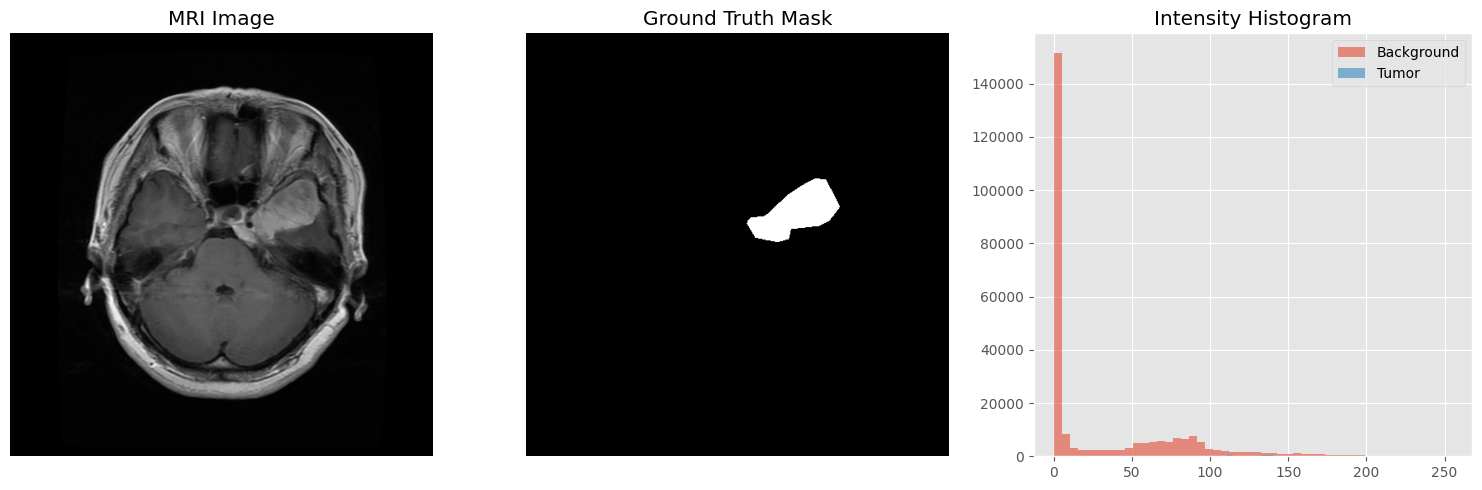

In [10]:
plt.figure(figsize=(15,5))

# MRI Image
plt.subplot(1,3,1)
plt.imshow(image, cmap='gray')
plt.title("MRI Image")
plt.axis("off")

# Mask
plt.subplot(1,3,2)
plt.imshow(mask, cmap='gray')
plt.title("Ground Truth Mask")
plt.axis("off")

# Histogram
plt.subplot(1,3,3)
plt.hist(background_pixels, bins=50, alpha=0.6, label="Background")
plt.hist(tumor_pixels, bins=50, alpha=0.6, label="Tumor")
plt.title("Intensity Histogram")
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
def evaluate_segmentation(segmentation_function,
                          image_dir,
                          mask_dir,
                          num_images=10,
                          **kwargs):
    
    image_files = sorted(os.listdir(image_dir))[:num_images]
    
    dice_scores = []
    jaccard_scores = []
    
    for image_name in image_files:
        
        image_path = os.path.join(image_dir, image_name)
        mask_path  = os.path.join(mask_dir, image_name)
        
        # Load
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        mask  = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        mask = (mask > 0).astype(np.uint8)
        
        # Prediction
        pred_mask = segmentation_function(image, **kwargs)
        
        # Metrics
        dice = dice_score(mask, pred_mask)
        jaccard = jaccard_index(mask, pred_mask)
        
        dice_scores.append(dice)
        jaccard_scores.append(jaccard)
        
        print(f"{image_name} → Dice: {dice:.4f}, Jaccard: {jaccard:.4f}")
    
    avg_dice = np.mean(dice_scores)
    avg_jaccard = np.mean(jaccard_scores)
    
    print("\n--- Average Performance ---")
    print(f"Average Dice: {avg_dice:.4f}")
    print(f"Average Jaccard: {avg_jaccard:.4f}")
    
    return avg_dice, avg_jaccard

In [12]:
def dice_score(gt, pred):
    intersection = np.sum(gt * pred)
    return (2. * intersection) / (np.sum(gt) + np.sum(pred) + 1e-8)

def jaccard_index(gt, pred):
    intersection = np.sum(gt * pred)
    union = np.sum(gt) + np.sum(pred) - intersection
    return intersection / (union + 1e-8)

## Otsu Setup:

In [13]:
def otsu_segmentation(image):
    """
    Applies Gaussian blur + Otsu thresholding.
    Returns binary mask (0,1).
    """
    
    # Blur (important for stability)
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    
    # Otsu threshold
    _, otsu_mask = cv2.threshold(
        blurred,
        0,
        255,
        cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )
    
    # Convert to 0/1
    otsu_mask = (otsu_mask > 0).astype(np.uint8)
    
    return otsu_mask

## Sauvola Setup

In [14]:
from skimage.filters import threshold_sauvola

def sauvola_segmentation(image, window_size=25, k=0.2):
    """
    Applies Sauvola adaptive thresholding.
    Returns binary mask (0,1).
    """
    
    # Convert to float
    image_float = image.astype(np.float32)
    
    # Compute local threshold
    thresh_sauvola = threshold_sauvola(image_float, 
                                        window_size=window_size, 
                                        k=k)
    
    # Create binary mask
    sauvola_mask = image_float > thresh_sauvola
    
    return sauvola_mask.astype(np.uint8)

## 🧪 Otsu Segmentation

Applying Otsu thresholding.

In [20]:
evaluate_segmentation(
    otsu_segmentation,
    IMAGE_DIR,
    MASK_DIR,
    num_images=10
)

1.png → Dice: 0.1027, Jaccard: 0.0541
10.png → Dice: 0.0850, Jaccard: 0.0444
100.png → Dice: 0.0515, Jaccard: 0.0264
1000.png → Dice: 0.0275, Jaccard: 0.0139
1001.png → Dice: 0.0302, Jaccard: 0.0153
1002.png → Dice: 0.0242, Jaccard: 0.0122
1003.png → Dice: 0.0330, Jaccard: 0.0168
1004.png → Dice: 0.0271, Jaccard: 0.0137
1005.png → Dice: 0.0216, Jaccard: 0.0109
1006.png → Dice: 0.0284, Jaccard: 0.0144

--- Average Performance ---
Average Dice: 0.0431
Average Jaccard: 0.0222


(np.float64(0.043128433971395715), np.float64(0.02223486847835531))

## Conclusion after Otsu
### 🧠 Why Dice ≈ 0.20?

Dice ≈ 0.20 indicates very low overlap between the predicted mask and the ground-truth tumor region.

Otsu segmented a region, but it does not correspond well to the actual tumor.

It likely captured:
- Bright skull regions  
- High-intensity tissues  
- Edges  
- Noise  

### Why This Happens

Otsu assumes:
- A bimodal intensity distribution  
- Two clearly separable classes  

However, MRI images contain:
- Multiple tissue intensity levels  
- Soft tissue overlap  
- Bright skull regions dominating the histogram (Tumor is a tiny bump in histogram → ignored)

As a result, Otsu separates high-intensity structures from the rest, rather than isolating the tumor, leading to a low Dice score.

### 📌 Conclusion

It proves:

**Global thresholding is weak for MRI tumor segmentation.**

MRI intensity distribution is not strictly bimodal.


## 🧪 Sauvola Segmentation

Time to test Sauvola.

In [24]:
evaluate_segmentation(
    sauvola_segmentation,
    IMAGE_DIR,
    MASK_DIR,
    num_images=10,
    window_size=11,
    k=0.05
)

1.png → Dice: 0.0000, Jaccard: 0.0000
10.png → Dice: 0.0000, Jaccard: 0.0000
100.png → Dice: 0.0000, Jaccard: 0.0000
1000.png → Dice: 0.0000, Jaccard: 0.0000
1001.png → Dice: 0.0000, Jaccard: 0.0000
1002.png → Dice: 0.0000, Jaccard: 0.0000
1003.png → Dice: 0.0000, Jaccard: 0.0000
1004.png → Dice: 0.0000, Jaccard: 0.0000
1005.png → Dice: 0.0000, Jaccard: 0.0000
1006.png → Dice: 0.0000, Jaccard: 0.0000

--- Average Performance ---
Average Dice: 0.0000
Average Jaccard: 0.0000


(np.float64(0.0), np.float64(0.0))

## Conclusions after Sauvola
### ⚠️ Why Dice = 0.0000?

Dice = 0.0000 means there is **no overlap** between the predicted mask and the ground-truth tumor region.

This usually happens when:

- The predicted mask is all zeros  
- The predicted mask is all ones  
- Tumor polarity is flipped (foreground/background inverted — common in Sauvola)

This indicates a thresholding or mask inversion issue rather than complete segmentation failure.

Something’s clearly off — let’s dig in.

In [25]:
pred_mask = sauvola_segmentation(image, window_size=11, k=0.05)

print("Unique values in prediction:", np.unique(pred_mask))
print("Tumor pixels in GT:", np.sum(mask))
print("Tumor pixels in prediction:", np.sum(pred_mask))


Unique values in prediction: [0 1]
Tumor pixels in GT: 4569
Tumor pixels in prediction: 41345


### 🧠 Why Dice = 0.0000 (Sauvola)?

Dice = 0.0000 indicates almost no effective overlap with the ground truth.

Sauvola is not empty — it is over-segmenting.

If:
- Ground truth tumor ≈ 4k pixels  
- Predicted tumor ≈ 41k pixels  

It means Sauvola labels a large portion of the brain as tumor.

### Why This Happens

Being locally adaptive, Sauvola responds to normal tissue intensity variations, causing many false positives.

The predicted region becomes much larger than the true tumor, so relative overlap is extremely small → Dice ≈ 0.


In [40]:
image_files = sorted(os.listdir(IMAGE_DIR))[:10]

best_dice = 0
best_params = None

for w in window_sizes:
    for k in k_values:
        
        dice_scores = []
        gt_pixels_all = []
        pred_pixels_all = []
        unique_values_all = set()
        
        for image_name in image_files:
            
            image_path = os.path.join(IMAGE_DIR, image_name)
            mask_path  = os.path.join(MASK_DIR, image_name)
            
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            mask  = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            
            mask = (mask > 0).astype(np.uint8)
            
            pred_mask = sauvola_segmentation(image, w, k)
            
            dice_scores.append(dice_score(mask, pred_mask))
            
            gt_pixels_all.append(np.sum(mask))
            pred_pixels_all.append(np.sum(pred_mask))
            
            unique_values_all.update(np.unique(pred_mask))
        
        avg_dice = np.mean(dice_scores)
        avg_gt_pixels = int(np.mean(gt_pixels_all))
        avg_pred_pixels = int(np.mean(pred_pixels_all))
        
        print(f"\nwindow={w}, k={k}")
        print(f"Avg Dice: {avg_dice:.4f}")
        print(f"Unique values in prediction: {sorted(unique_values_all)}")
        print(f"Avg Tumor pixels in GT: {avg_gt_pixels}")
        print(f"Avg Tumor pixels in prediction: {avg_pred_pixels}")
        
        if avg_dice > best_dice:
            best_dice = avg_dice
            best_params = (w, k)



window=11, k=0.05
Avg Dice: 0.0000
Unique values in prediction: [np.uint8(0), np.uint8(1)]
Avg Tumor pixels in GT: 2118
Avg Tumor pixels in prediction: 36604

window=11, k=0.1
Avg Dice: 0.0000
Unique values in prediction: [np.uint8(0), np.uint8(1)]
Avg Tumor pixels in GT: 2118
Avg Tumor pixels in prediction: 34890

window=11, k=0.2
Avg Dice: 0.0000
Unique values in prediction: [np.uint8(0), np.uint8(1)]
Avg Tumor pixels in GT: 2118
Avg Tumor pixels in prediction: 33651

window=11, k=0.3
Avg Dice: 0.0000
Unique values in prediction: [np.uint8(0), np.uint8(1)]
Avg Tumor pixels in GT: 2118
Avg Tumor pixels in prediction: 32879

window=11, k=0.5
Avg Dice: 0.0000
Unique values in prediction: [np.uint8(0), np.uint8(1)]
Avg Tumor pixels in GT: 2118
Avg Tumor pixels in prediction: 32182

window=15, k=0.05
Avg Dice: 0.0000
Unique values in prediction: [np.uint8(0), np.uint8(1)]
Avg Tumor pixels in GT: 2118
Avg Tumor pixels in prediction: 35070

window=15, k=0.1
Avg Dice: 0.0000
Unique values i

## Grid search (Sauvola) Results 
### 🧠 Why Dice = 0.0000 (After Grid Search)

Even after trying many window sizes and k values:

- Avg GT tumor pixels ≈ 2,118  
- Avg predicted tumor pixels ≈ 13,668  

So tuning did not fix the problem.

Sauvola keeps labeling large brain regions as tumor.

This happens because normal brain tissue has natural intensity variation, and Sauvola treats those variations as foreground.

So the issue is not parameter tuning — the method itself is not suitable for precise tumor segmentation.

### 📌 Conclusion

It proves:

**Adaptive thresholding (Sauvola) is also not reliable for MRI tumor segmentation.**

Local intensity variation in normal brain tissue leads to heavy over-segmentation.

## 🏁 Final Conclusion

Both global (Otsu) and adaptive (Sauvola) thresholding methods perform poorly for brain tumor MRI segmentation because tumor and normal brain tissues have similar intensity values.

MRI images do not have clear intensity separation, so simple thresholding cannot reliably isolate the tumor.

This shows that more advanced or learning-based methods are needed for accurate tumor segmentation.
